In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


sns.set_theme(style="whitegrid")

In [2]:
#load the dataset
df = pd.read_csv("social_media_engagement_dataset.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   platform         10000 non-null  object 
 1   post_type        10000 non-null  object 
 2   post_length      10000 non-null  int64  
 3   views            10000 non-null  int64  
 4   likes            10000 non-null  int64  
 5   comments         10000 non-null  int64  
 6   shares           10000 non-null  int64  
 7   engagement_rate  10000 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 625.1+ KB
None


In [3]:
#handling missing values
print(df.isnull().sum())

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(include=['object', 'string']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print(df.isnull().sum())

platform           0
post_type          0
post_length        0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
dtype: int64
platform           0
post_type          0
post_length        0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
dtype: int64


In [4]:
#create a new column for total engagement
df['Total_Engagement'] = df['likes'] + df['comments'] + df['shares']

In [5]:
#encoding categorical variables
data_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print(data_encoded.head())

   post_length   views  likes  comments  shares  engagement_rate  \
0           62   91660   2968       276     346         0.039166   
1          104  113115   4164       632     406         0.045989   
2           46   36043   3125       188     100         0.094692   
3           39  124886   5970       948     578         0.060023   
4           42   82831   8212      1104     334         0.116502   

   Total_Engagement  platform_Instagram  platform_Twitter  post_type_Text  \
0              3590               False             False            True   
1              5202                True             False           False   
2              3413               False             False           False   
3              7496               False             False           False   
4              9650                True             False           False   

   post_type_Video  
0            False  
1             True  
2             True  
3            False  
4             True  


In [6]:
#exploratory data analysis
#summary statistics for numeric columns
print(df[['likes', 'comments', 'shares', 'Total_Engagement']].describe())


             likes      comments        shares  Total_Engagement
count  10000.00000  10000.000000  10000.000000      10000.000000
mean    7033.26920    879.232800    602.262700       8514.764700
std     5673.59828    812.409438    597.573391       6898.648386
min       35.00000      3.000000      2.000000         43.000000
25%     2513.75000    275.000000    170.000000       3029.750000
50%     5580.50000    635.000000    406.000000       6732.000000
75%    10276.50000   1228.000000    837.000000      12391.250000
max    29486.00000   5435.000000   3861.000000      38270.000000


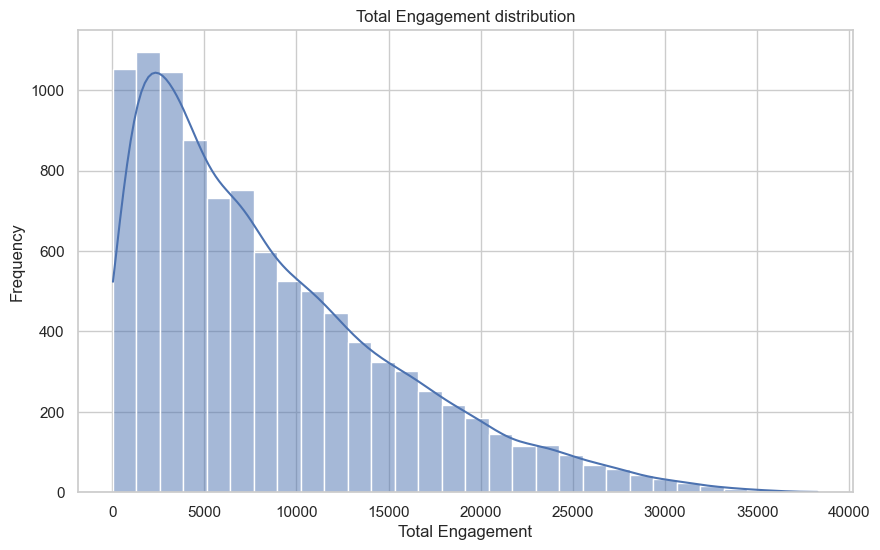

In [7]:
#total engagement distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Engagement'], bins=30, kde=True)
plt.title('Total Engagement distribution')
plt.xlabel('Total Engagement')
plt.ylabel('Frequency')
plt.show()

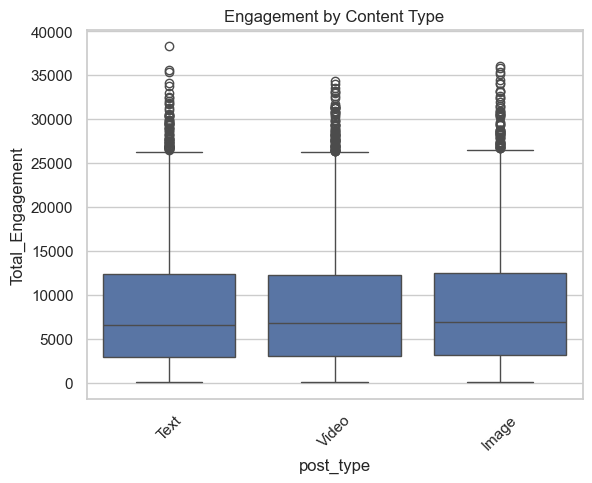

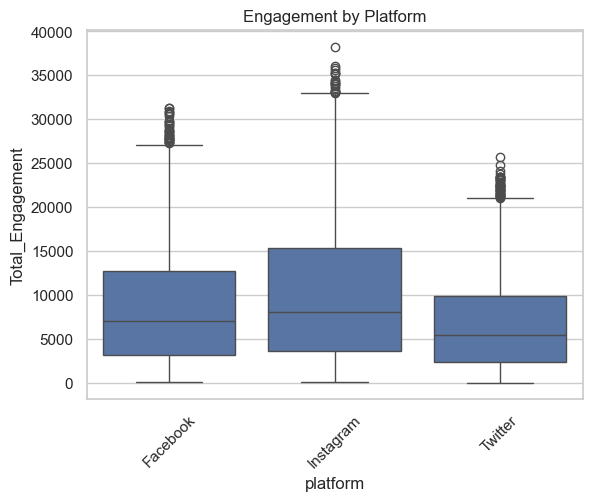

In [8]:
#user engagement by content type
plt.figure()
sns.boxplot(x='post_type', y='Total_Engagement', data=df)
plt.title("Engagement by Content Type")
plt.xticks(rotation=45)
plt.show()

#user engagement by platform
plt.figure()
sns.boxplot(x='platform', y='Total_Engagement', data=df)
plt.title("Engagement by Platform")
plt.xticks(rotation=45)
plt.show()

  post_type   platform  Total_Engagement
0     Image   Facebook       8884.993728
1     Image  Instagram      10273.122650
2     Image    Twitter       6652.149516
3      Text   Facebook       8431.325688
4      Text  Instagram      10048.198556
5      Text    Twitter       6715.414923
6     Video   Facebook       8458.156450
7     Video  Instagram      10415.787422
8     Video    Twitter       6737.572457


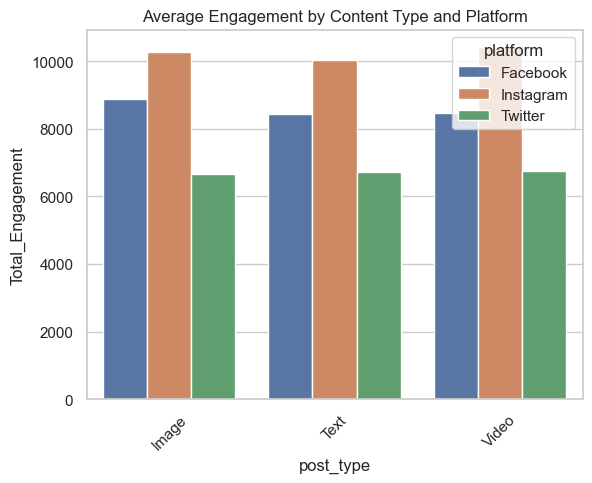

In [9]:
#average engagement by content type and platform
grouped = df.groupby(['post_type', 'platform'])['Total_Engagement'].mean().reset_index()
print(grouped)
plt.figure()
sns.barplot(x='post_type', y='Total_Engagement', hue='platform', data=grouped)
plt.title("Average Engagement by Content Type and Platform")
plt.xticks(rotation=45)
plt.show()


                     likes  comments    shares  Total_Engagement
likes             1.000000  0.877651  0.825058          0.997245
comments          0.877651  1.000000  0.720223          0.901950
shares            0.825058  0.720223  1.000000          0.849983
Total_Engagement  0.997245  0.901950  0.849983          1.000000


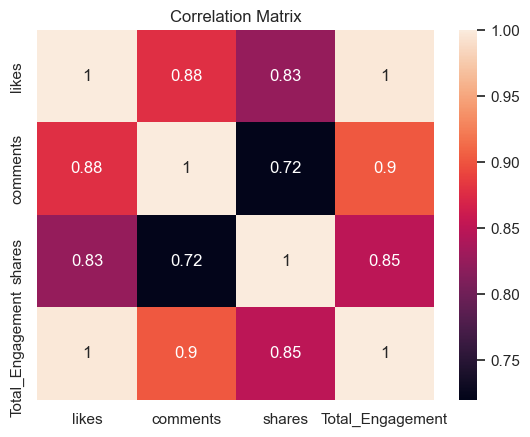

In [10]:
#Statistical analysis
#correlation analysis
corr = df[['likes', 'comments', 'shares', 'Total_Engagement']].corr()
print(corr)
plt.figure()
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [11]:

#ANOVA test for post type and engagement
groups_postType = [group['Total_Engagement'].values for name, group in df.groupby('post_type')]
anova_postType = stats.f_oneway(*groups_postType)
print("ANOVA Result for post Type:")
print("F-statistic:", anova_postType.statistic)
print("p-value:", anova_postType.pvalue)

#ANOVA test for platform and engagement
groups_platform = [group['Total_Engagement'].values for name, group in df.groupby('platform')]
anova_platform = stats.f_oneway(*groups_platform)
print("ANOVA Result for Platform:")
print("F-statistic:", anova_platform.statistic)
print("p-value:", anova_platform.pvalue)


ANOVA Result for post Type:
F-statistic: 0.6827291186470595
p-value: 0.5052598149334004
ANOVA Result for Platform:
F-statistic: 231.80562295721168
p-value: 3.914527737508569e-99


In [12]:
#Regression analysis
a = data_encoded.drop(columns=['Total_Engagement']).astype(float)
b = data_encoded['Total_Engagement']
C = sm.add_constant(a)
model = sm.OLS(b, C).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Total_Engagement   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.927e+32
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:20:20   Log-Likelihood:             2.3458e+05
No. Observations:               10000   AIC:                        -4.691e+05
Df Residuals:                    9989   BIC:                        -4.691e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.876e-12   8.44

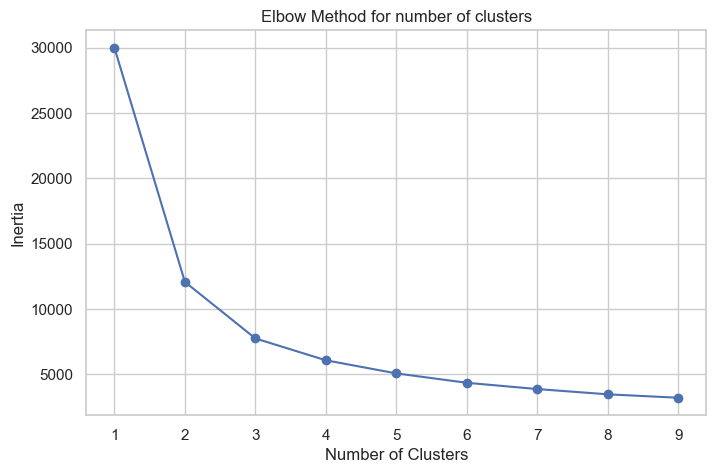

Cluster Summary:
                 likes     comments       shares
Cluster                                        
0        10002.389043  1212.536781   816.832564
1         3027.582410   356.770826   236.822488
2        18062.777874  2469.334486  1766.597234


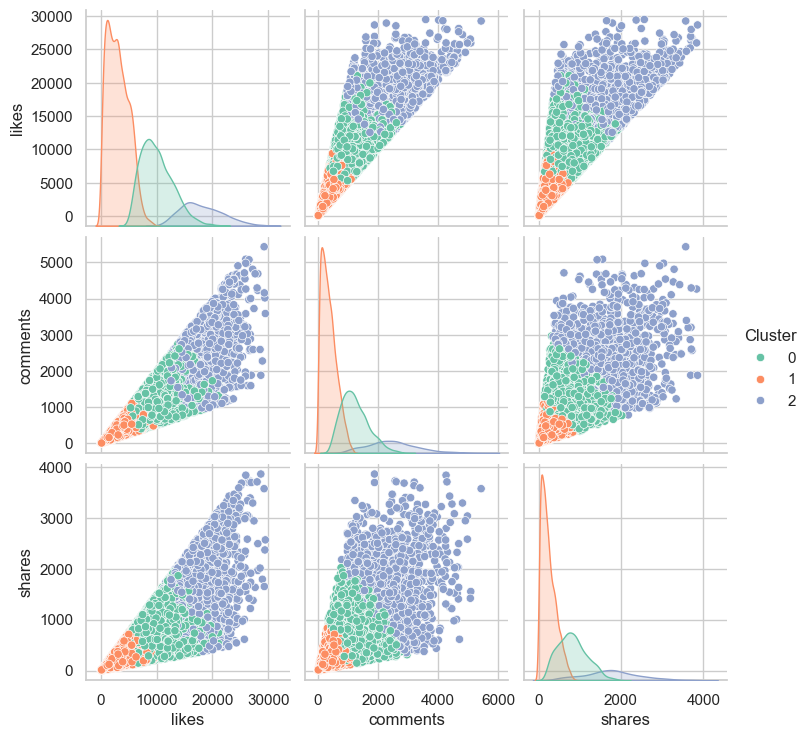

In [14]:
# KMeans clustering
cluster_cols = df[['likes', 'comments', 'shares']]

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_cols)
inertia = []
k_range = range(1, 10) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for number of clusters')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

summary = df.groupby('Cluster')[['likes', 'comments', 'shares']].mean()
print("Cluster Summary:\n", summary)

sns.pairplot(df, vars=['likes','comments','shares'], hue='Cluster', palette='Set2')
plt.show()
